<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-модели" data-toc-modified-id="Анализ-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Анализ модели</a></span></li></ul></div>

# Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

# Импорт библиотек

In [2]:
import tensorflow
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Исследовательский анализ данных

Проведите исследовательский анализ данных:

* Посмотрите на размер выборки.
* Постройте график распределения возраста в выборке.
* Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.
* Сделайте выводы о том, как результаты исследования повлияют на обучение модели.

Загрузим данные с сервера

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(233, 233),
        batch_size=12,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Загрузчик обнаружил 7591 фотографий. Сохраним в отдельные переменные сами фотографии и метки возраста для каждой

In [3]:
features, target = next(train_gen_flow)

Рассмотрим размеры этих переменных

In [4]:
display(features.shape)
display(target.shape)

(12, 233, 233, 3)

(12,)

Все верно, в батче 12 фотографий разрешением 233х233 и тремя каналами (то есть цветных)
Выведем эти фотографии из батча

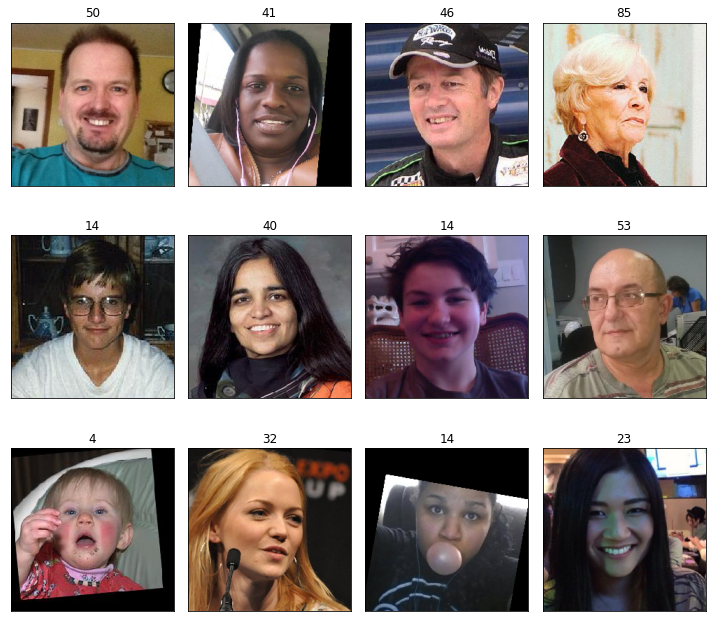

In [5]:
fig = plt.figure(figsize=(10,10))
for i in range(3*4):
    person = fig.add_subplot(3, 4, i+1)
    person.set_title(target[i])
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Рассмотрим распределение возрастов в датасете

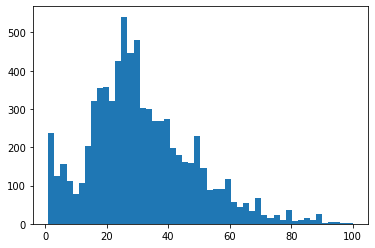

In [6]:
plt.hist(labels['real_age'], bins=50);

В датасете явный дисбаланс в пользу детей и тридцатилетних. Вероятно, это снизит точность распознавания людей другого возраста, если не применять аугментации для компенсации дисбаланса

# Обучение модели

Обучите модель в GPU-тренажёре и сохраните результат вывода модели на экран.

Но прежде ознакомьтесь с несколькими рекомендациями:
Функцией потерь не обязательно должна быть MAE. Зачастую нейронные сети с функцией потерь MSE обучаются быстрее.
Качество на валидационной выборке улучшается, но модель при этом переобучается всё сильнее? Не спешите менять модель. Обычно нейронные сети с большим числом слоёв сильно переобучаются.

In [1]:
def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen_test = ImageDataGenerator(rescale=(1.0/255.0), validation_split=0.2)

    test_datagen_flow = datagen_test.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def load_train(path=None):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    datagen_train = ImageDataGenerator(rescale=(1.0/255.0), validation_split=0.2, rotation_range=15, 
                                  width_shift_range=0.2, height_shift_range=0.2)

    train_datagen_flow = datagen_train.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256), 
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate = 0.0001) 

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=16, activation='relu')) #
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=30,
                steps_per_epoch=None, validation_steps=None): 

    if steps_per_epoch == None:
        steps_per_epoch = len(train_datagen_flow)
    if validation_steps == None:
        validation_steps = len(val_datagen_flow)

    model.fit(train_datagen_flow,  
              validation_data=val_datagen_flow,
              steps_per_epoch=steps_per_epoch, 
              epochs=epochs,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

In [ ]:
2022-05-28 17:31:22.381623: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-05-28 17:31:22.383302: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 6073 validated image filenames.
Found 1518 validated image filenames.
2022-05-28 17:31:23.221850: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-28 17:31:23.899109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-28 17:31:23.899192: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-28 17:31:23.899225: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-28 17:31:23.901016: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-28 17:31:23.901414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-28 17:31:23.903565: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-28 17:31:23.904720: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-28 17:31:23.904783: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-28 17:31:23.909254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-28 17:31:23.909608: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-05-28 17:31:23.916643: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-05-28 17:31:23.917215: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5936ba0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-28 17:31:23.917238: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-05-28 17:31:24.065491: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x59bcbc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-05-28 17:31:24.065538: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-05-28 17:31:24.068065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-28 17:31:24.068128: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-28 17:31:24.068138: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-28 17:31:24.068165: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-05-28 17:31:24.068175: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-05-28 17:31:24.068184: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-05-28 17:31:24.068194: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-05-28 17:31:24.068201: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-05-28 17:31:24.072940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-05-28 17:31:24.073017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-05-28 17:31:24.379591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-05-28 17:31:24.379640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-05-28 17:31:24.379647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-05-28 17:31:24.384250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 380 steps, validate for 95 steps
Epoch 1/30
2022-05-28 17:31:35.365968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-05-28 17:31:35.654612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 118s - loss: 237.2936 - mae: 11.1016 - val_loss: 300.4832 - val_mae: 13.0234
Epoch 2/30
380/380 - 111s - loss: 101.4993 - mae: 7.6302 - val_loss: 115.9202 - val_mae: 7.9486
Epoch 3/30
380/380 - 110s - loss: 76.7746 - mae: 6.6691 - val_loss: 84.7725 - val_mae: 6.8215
Epoch 4/30
380/380 - 110s - loss: 61.8214 - mae: 5.9877 - val_loss: 76.5606 - val_mae: 6.3425
Epoch 5/30
380/380 - 110s - loss: 50.8460 - mae: 5.4637 - val_loss: 98.6616 - val_mae: 7.2714
Epoch 6/30
380/380 - 110s - loss: 41.8113 - mae: 5.0076 - val_loss: 109.6497 - val_mae: 7.8897
Epoch 7/30
380/380 - 110s - loss: 35.6801 - mae: 4.5879 - val_loss: 76.3616 - val_mae: 6.4163
Epoch 8/30
380/380 - 110s - loss: 31.2420 - mae: 4.3117 - val_loss: 112.0851 - val_mae: 8.3274
Epoch 9/30
380/380 - 110s - loss: 24.6692 - mae: 3.8529 - val_loss: 83.8873 - val_mae: 6.8656
Epoch 10/30
380/380 - 110s - loss: 24.3606 - mae: 3.7797 - val_loss: 74.8156 - val_mae: 6.5820
Epoch 11/30
380/380 - 110s - loss: 23.0389 - mae: 3.6834 - val_loss: 69.5400 - val_mae: 6.0816
Epoch 12/30
380/380 - 111s - loss: 21.0427 - mae: 3.5220 - val_loss: 72.1309 - val_mae: 6.3245
Epoch 13/30
380/380 - 110s - loss: 17.8551 - mae: 3.2741 - val_loss: 68.2909 - val_mae: 6.2692
Epoch 14/30
380/380 - 110s - loss: 15.9892 - mae: 3.0925 - val_loss: 63.9923 - val_mae: 5.8780
Epoch 15/30
380/380 - 111s - loss: 15.7007 - mae: 3.0443 - val_loss: 71.7426 - val_mae: 6.2717
Epoch 16/30
380/380 - 111s - loss: 15.0603 - mae: 2.9731 - val_loss: 70.2514 - val_mae: 6.4070
Epoch 17/30
380/380 - 111s - loss: 14.8233 - mae: 2.9591 - val_loss: 72.1381 - val_mae: 6.1917
Epoch 18/30
380/380 - 110s - loss: 13.4816 - mae: 2.8233 - val_loss: 58.7539 - val_mae: 5.6287
Epoch 19/30
380/380 - 110s - loss: 12.4527 - mae: 2.7241 - val_loss: 60.8011 - val_mae: 5.8080
Epoch 20/30
380/380 - 110s - loss: 13.2203 - mae: 2.7995 - val_loss: 64.0644 - val_mae: 5.7748
Epoch 21/30
380/380 - 110s - loss: 12.5870 - mae: 2.7210 - val_loss: 59.6015 - val_mae: 5.6886
Epoch 22/30
380/380 - 111s - loss: 11.2896 - mae: 2.5984 - val_loss: 70.0642 - val_mae: 6.0604
Epoch 23/30
380/380 - 110s - loss: 13.0958 - mae: 2.7564 - val_loss: 69.5463 - val_mae: 5.9933
Epoch 24/30
380/380 - 110s - loss: 12.4490 - mae: 2.6993 - val_loss: 63.5820 - val_mae: 5.8733
Epoch 25/30
380/380 - 110s - loss: 10.9126 - mae: 2.5358 - val_loss: 58.7264 - val_mae: 5.5786
Epoch 26/30
380/380 - 111s - loss: 12.6541 - mae: 2.6935 - val_loss: 73.8939 - val_mae: 6.2174
Epoch 27/30
380/380 - 110s - loss: 10.6059 - mae: 2.4792 - val_loss: 57.2941 - val_mae: 5.5937
Epoch 28/30
380/380 - 110s - loss: 9.5038 - mae: 2.3741 - val_loss: 56.4263 - val_mae: 5.4328
Epoch 29/30
380/380 - 110s - loss: 8.3862 - mae: 2.2211 - val_loss: 53.2089 - val_mae: 5.3398
Epoch 30/30
380/380 - 110s - loss: 8.5188 - mae: 2.2189 - val_loss: 62.5426 - val_mae: 5.8634
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 62.5426 - mae: 5.8634
Test MAE: 5.8634

# Анализ модели

* За тридцать эпох была достигунта метрика MAE 5.86, на промежуточных эпохах MAE на валидационной выборке опускалась до 5.34
* Это было достигнуто при помощи приемлемых для изображений человеческого лица аугментаций (смещения и незначительные повороты)
* В качестве базовой модели была взята ResNet50 с добавленным сверточным слоем, скрытым полносвязным и полносвязным выходным слоем
* Для обучения сети выбран алгоритм Adam с маленьким шагом learning_rate=0.0001
* В качестве функции потерь выбрана MSE